In [427]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score,
    confusion_matrix,
    f1_score,
    recall_score,
    precision_score)
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier


In [379]:
def param_heat(results, param_grid, param_x, param_y):

    param_x_r = param_grid[param_x]
    param_y_r = param_grid[param_y]
    scores = results['mean_test_f1'].values.reshape(len(param_y_r), len(param_x_r))

    plt.figure(figsize=(8, 6))
    sns.heatmap(scores, annot=True, xticklabels=param_x_r, yticklabels=param_y_r, cmap="viridis")

    plt.xlabel(str(param_x))
    plt.ylabel(str(param_y))
    plt.title('Heatmap de Resultados')

    plt.show()

In [380]:
def param_graph(dataset, x_param, z_param):
    plt.figure(figsize=(10, 6))
    
    dataset[z_param] = dataset[z_param].astype(float)
    n_estimators_values = dataset[z_param].unique()
    colors = plt.cm.get_cmap('tab10', len(n_estimators_values))


    for i, n in enumerate(n_estimators_values):
        subset = dataset[dataset[z_param] == n]

        color = colors(i)

        mean_scores = subset.groupby(x_param).agg({
                'mean_train_f1': 'mean',
                'mean_test_f1': 'mean'
            }).reset_index()
        plt.plot(mean_scores[x_param], mean_scores['mean_train_f1'],
                label=f'Train Score ({z_param}={n})', linestyle='-', marker='o', color = color)
        
        plt.plot(mean_scores[x_param], mean_scores['mean_test_f1'],
                label=f'Test Score ({z_param}={n})', linestyle='--', marker='o', color = color)

    plt.title('Train y Test Score por ')
    plt.xlabel('Max Depth')
    plt.ylabel('Score')
    plt.legend(loc='best', fontsize = 'small')

    plt.show()




In [381]:
def conf_matrix(y_test, y_pred):
                     
    recall = recall_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.title('Matriz de Confusión')
    plt.show()

In [428]:
def training(model, data, param_grid):
    X = data.drop('Outcome', axis=1)
    y = data['Outcome']
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=8)
    
    imputer = IterativeImputer()
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)

    # smote = SMOTE()
    # X_train, y_train = smote.fit_resample(X_train, y_train)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    scoring = {
        'accuracy': 'accuracy',
        'f1': 'f1',
        'precision': 'precision',
        'recall': 'recall'
    }    
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

    grid_search = GridSearchCV(model, param_grid=param_grid, cv=cv, n_jobs=-1,
                                return_train_score=True, scoring=scoring, refit = 'f1')
    
    grid_search.fit(X_train, y_train)

    cv_results = pd.DataFrame(grid_search.cv_results_)
    
    print('Los mejores parámetros son:', grid_search.best_params_)
    print('El score de entrenamiento es:', cv_results['mean_train_f1'].iloc[grid_search.best_index_])
    print('El mejor score es:', grid_search.best_score_)
    
    metrics_df = pd.DataFrame({
    'Mean Test Accuracy': [cv_results['mean_test_accuracy'].iloc[grid_search.best_index_]],
    'Mean Test F1': [cv_results['mean_test_f1'].iloc[grid_search.best_index_]],
    'Mean Test Precision': [cv_results['mean_test_precision'].iloc[grid_search.best_index_]],
    'Mean Test Recall': [cv_results['mean_test_recall'].iloc[grid_search.best_index_]]
    }, index=[model.__class__.__name__])

    return cv_results, grid_search, X_test, y_test, metrics_df


In [425]:
data = pd.read_csv('datos_limpios.csv')

In [429]:
knn_params = {'n_neighbors' : range(1, 50)}

knn_results, knn_grid, X_test, y_test, knn_metrics = training(KNeighborsClassifier(), data, knn_params)


Los mejores parámetros son: {'n_neighbors': 9}
El score de entrenamiento es: 0.7136921797431162
El mejor score es: 0.6462840597840009


In [430]:
knn_grid.best_params_

{'n_neighbors': 9}

In [431]:
knn_metrics

,Mean Test Accuracy,Mean Test F1,Mean Test Precision,Mean Test Recall
KNeighborsClassifier,0.772553,0.646284,0.708263,0.599114


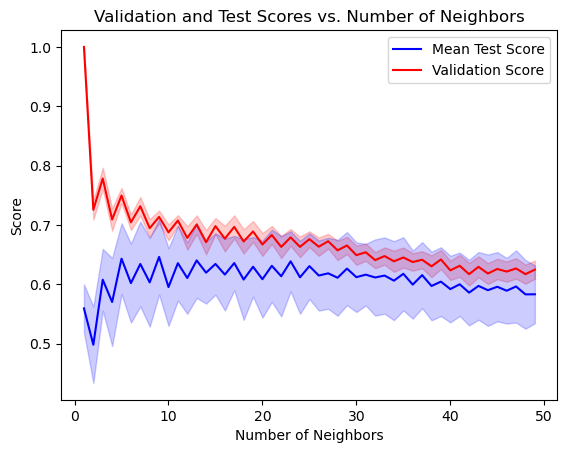

In [432]:
param = 'param_n_neighbors'
score_p = ['mean_test_f1', 'mean_train_f1']
std_p = ['std_test_f1', 'std_train_f1']
knn_results[param] = knn_results[param].astype(float)
fig, ax = plt.subplots()

ax.plot(knn_results[param], 
        knn_results[score_p[0]], 
        label='Mean Test Score',
        color = 'blue') 

ax.plot(knn_results[param], 
        knn_results[score_p[1]], 
        label='Validation Score', 
        color='red') 

ax.fill_between(knn_results[param], 
                (knn_results[score_p[1]] - knn_results[std_p[1]]), 
                (knn_results[score_p[1]] + knn_results[std_p[1]]), 
                color='red', alpha=0.2)

ax.fill_between(knn_results[param], 
                (knn_results[score_p[0]] - knn_results[std_p[0]]), 
                (knn_results[score_p[0]] + knn_results[std_p[0]]), 
                color='blue', alpha=0.2)
 
ax.set_xlabel('Number of Neighbors')
ax.set_ylabel('Score')
ax.set_title('Validation and Test Scores vs. Number of Neighbors')

ax.legend()

plt.show()

Recall: 0.7170
Precision: 0.6032
F1 Score: 0.6552
Accuracy: 0.7386


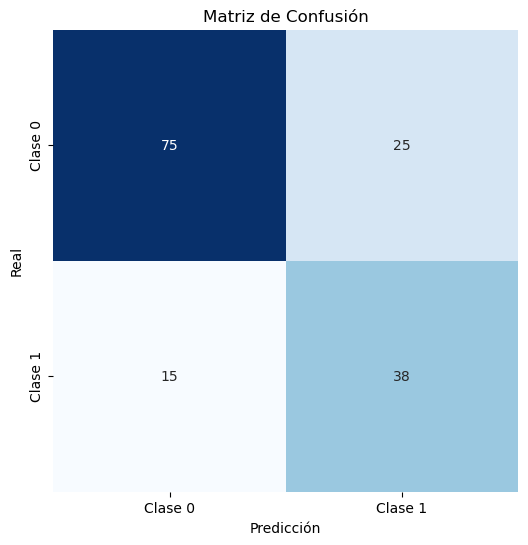

In [433]:
knn_pred = knn_grid.predict(X_test)
conf_matrix(y_test, knn_pred)

# RANDOM FOREST

In [389]:
rf_param = {
    'n_estimators': [50, 70, 90, 100, 200],
    'max_depth': range(1,9)
}

rf_results, rf, X_test_rf, y_test_rf, rf_metrics = training(RandomForestClassifier(), data, rf_param)


Los mejores parámetros son: {'max_depth': 4, 'n_estimators': 90}
El score de entrenamiento es: 0.772258466907643
El mejor score es: 0.6571609025448688


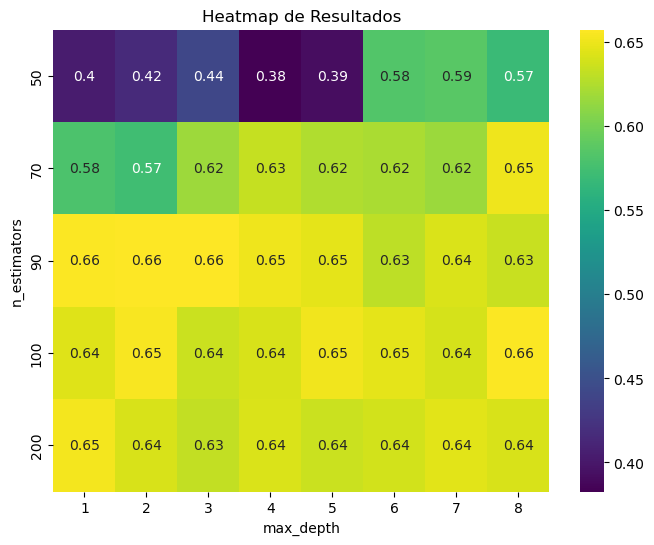

In [390]:
param_heat(rf_results, rf_param, 'max_depth', 'n_estimators')

Recall: 0.5283
Precision: 0.5957
F1 Score: 0.5600
Accuracy: 0.7124


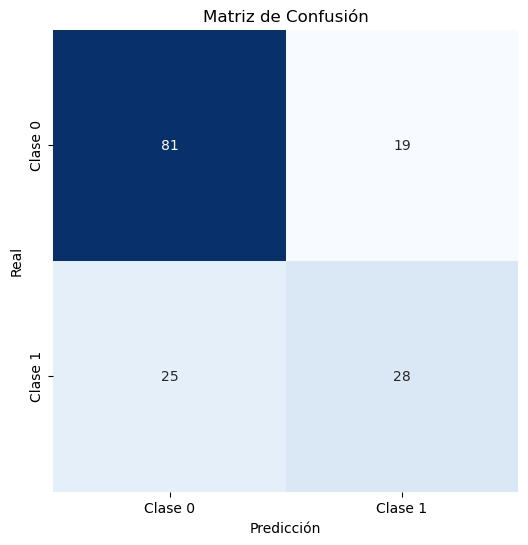

In [391]:
y_pred = rf.predict(X_test_rf)
conf_matrix(y_test_rf, y_pred)

# GRADIENT BOOSTING

In [392]:
gb_param = {
    'n_estimators': [10, 20, 50, 100],
    'max_depth': range(1,5),
    'learning_rate': [0.01, 0.1, 0.3, 0.001]#,
    #'subsample': [0.7, 1]
}
gb_results, gb, X_test, y_test, gb_metrics = training(GradientBoostingClassifier(), data, gb_param)

Los mejores parámetros son: {'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 20}
El score de entrenamiento es: 0.9666537813303835
El mejor score es: 0.6584581713095768


max_depth =  1


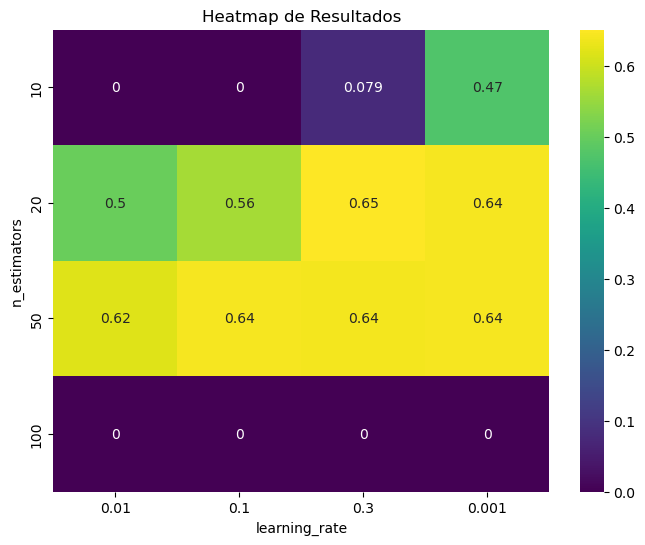

max_depth =  2


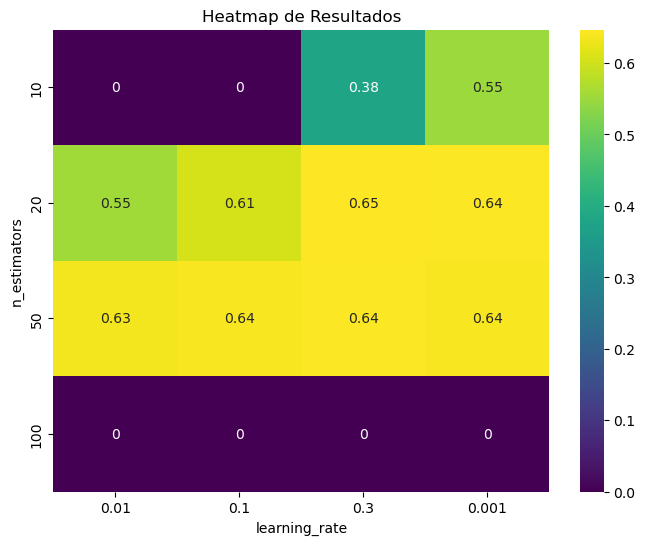

max_depth =  3


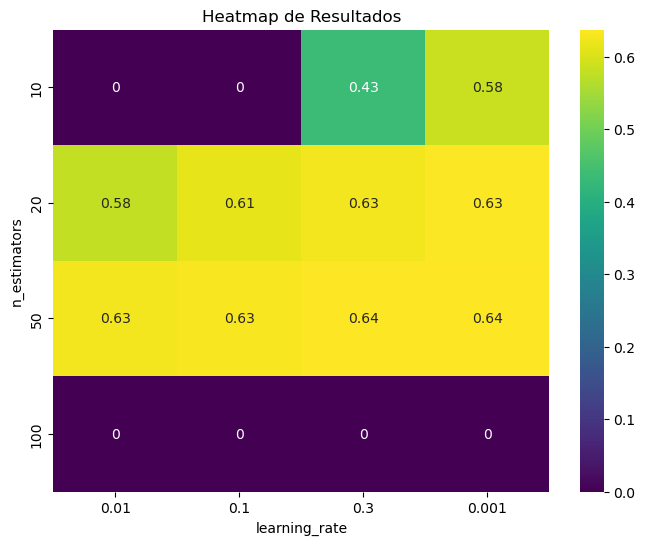

max_depth =  4


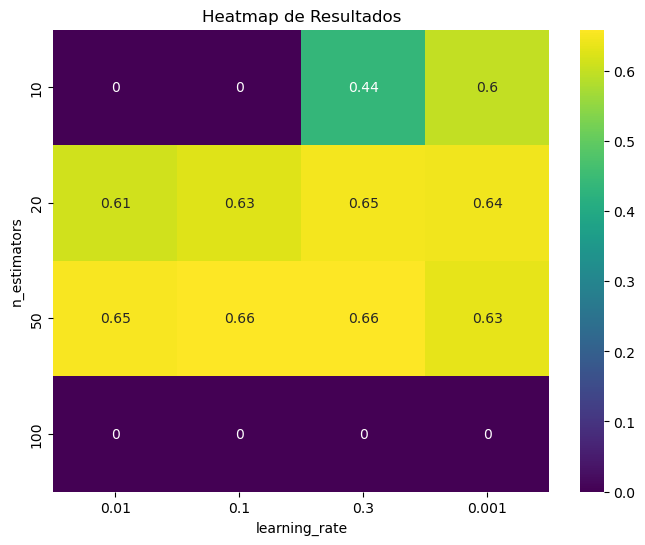

In [393]:
x_param = 'learning_rate'
z_param = 'n_estimators'
max_depth = 'param_max_depth'

for i in gb_results[max_depth].unique():
    subset = gb_results[gb_results[max_depth] == i]
    print('max_depth = ', i)
    param_heat(subset, gb_param, x_param, z_param)


Recall: 0.6792
Precision: 0.6000
F1 Score: 0.6372
Accuracy: 0.7320


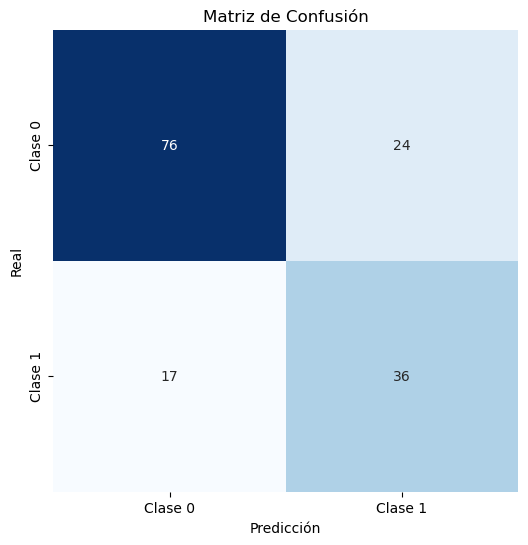

In [394]:
y_pred = gb.predict(X_test)
conf_matrix(y_test, y_pred)

# XGBOOST


In [407]:
xgb_params = {'max_depth' : range(2, 5),
              'learning_rate' : [0.3, 0.1, 0.03, 0.01],
                # 'subsample':[0.5, 0.6],
                # 'colsample_bytree': [0.5, 1],
                # 'reg_alpha': [0, 0.1, 1, 10],
                # 'reg_lambda': [0, 0.1, 1, 10],
                # 'gamma': [0, 0.1, 1, 10],
                'scale_pos_weight' : [1, 1.5, 2, 3]
    }

xgb_results, xgb, X_test, y_test, xgb_metrics = training(XGBClassifier(), data, xgb_params)

Los mejores parámetros son: {'learning_rate': 0.03, 'max_depth': 2, 'scale_pos_weight': 2}
El score de entrenamiento es: 0.7615480438207172
El mejor score es: 0.7250087548219475


Recall: 0.7736
Precision: 0.5541
F1 Score: 0.6457
Accuracy: 0.7059


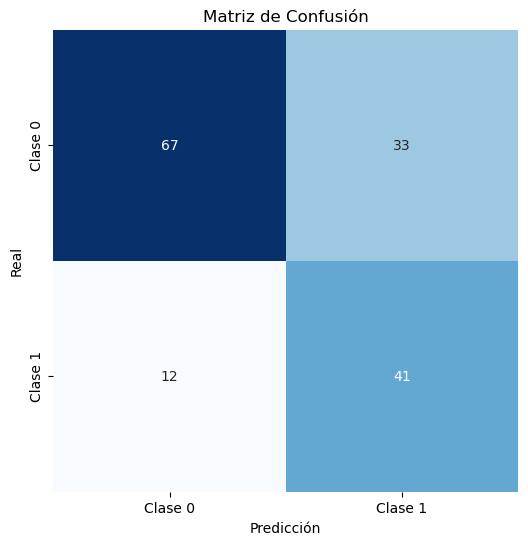

In [408]:
y_pred = xgb.best_estimator_.predict(X_test)
conf_matrix(y_test, y_pred)

In [397]:
metrics = pd.concat([knn_metrics,rf_metrics, gb_metrics, xgb_metrics])


In [398]:
metrics

,Mean Test Accuracy,Mean Test F1,Mean Test Precision,Mean Test Recall
KNeighborsClassifier,0.738091,0.624521,0.639704,0.625028
RandomForestClassifier,0.779022,0.657161,0.720674,0.605648
GradientBoostingClassifier,0.770838,0.658458,0.685432,0.633998
XGBClassifier,0.778942,0.725009,0.644818,0.831118


In [399]:
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

X= data.drop('Outcome',  axis = 1)
y = data['Outcome']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
    
imputer = KNNImputer()
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)
    
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

clf1 = KNeighborsClassifier(n_neighbors=9)
clf2 = RandomForestClassifier(n_estimators=90, max_depth=8, random_state=42)

meta_model = XGBClassifier(learning_rate= 0.01, max_depth = 2, scale_pos_weight = 1)


stacking_clf = StackingClassifier(
    estimators=[('knn', clf1), ('rf', clf2),],
    final_estimator=meta_model,
    cv=5
)

stacking_clf.fit(X_train, y_train)
accuracy = stacking_clf.score(X_test, y_test)
print(f"Accuracy del modelo de stacking: {accuracy:.4f}")


Accuracy del modelo de stacking: 0.7712


Recall: 0.7660
Precision: 0.6000
F1 Score: 0.6729
Accuracy: 0.7712


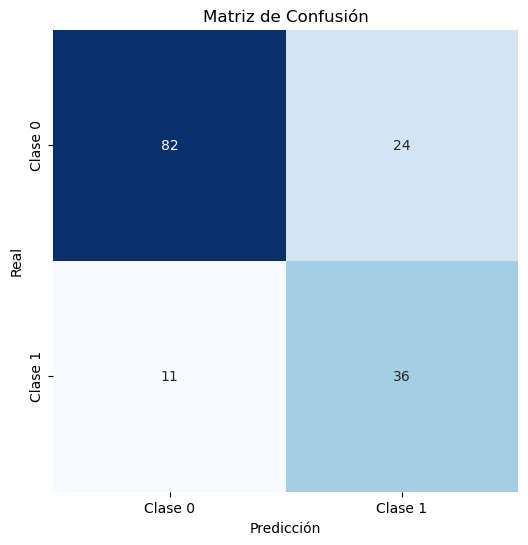

In [400]:
conf_matrix(y_test ,stacking_clf.predict(X_test))